In [1]:
from os import getcwd, path
import sys

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

In [2]:
MODEL_PATH = path.join(BASE_PATH, 'output/model/nli_model_4_76.1.bin')
print(MODEL_PATH)

/Users/2359media/Documents/botbot-nlp/output/model/nli_model_4_76.1.bin


In [3]:
import torch
from sent_to_vec.model import *

encoder = BiGRUEncoder()
nli_net = NLINet(encoder=encoder)
nli_net.load_state_dict(torch.load(MODEL_PATH, map_location=lambda storage, loc: storage))

In [4]:
def encode(sent):
    sent_input = [sent]
    sent_batch, sent_len = process_batch(sent_input)
    embs = encoder((sent_batch, sent_len))[0]
    return embs.data.numpy()

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [5]:
embs = encode('I\'d like to order a coffee')
print(embs)

Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
[ 0.00110875  0.00283974  0.00033141 ...  0.00417233 -0.01161623
 -0.00818001]


In [6]:
cosine(encode('I\'d like a coffee'), encode('Can I order some food?'))

0.7713651

In [7]:
cosine(encode('I like cats'), encode('I don\'t like cats, I like dogs instead'))

0.8290323

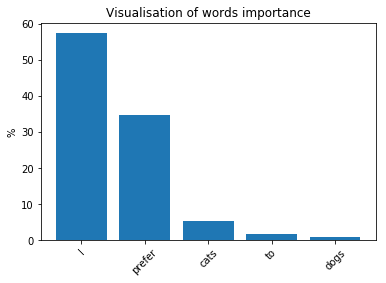

In [10]:
import matplotlib.pyplot as plt

sent_input = ['I prefer cats to dogs']
sent_batch, sent_len = process_batch(sent_input)

sent, _, _ = process_input(sent_input)

output = encoder.lstm(sent_batch)[0]
output, idxs = torch.max(output, 0)
idxs = idxs.data.numpy()

x = range(len(sent[0]))
argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]
y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
plt.xticks(x, sent[0], rotation=45)
plt.bar(x, y)
plt.ylabel('%')
plt.title('Visualisation of words importance')
plt.show()